In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install d2l==0.17.6

In [ ]:
import os
path = '/content/drive/MyDrive'
os.chdir(path)

!source venv_d2l/bin/activate

path = '/content/drive/MyDrive/d2l-zh'
os.chdir(path)

In [ ]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 使用三阶多项式来生成训练和测试数据的表情
# 这里的测试其实就是验证数据集的意思
# w产生一个20维的向量，只有前面4个是有值的，后面都为0

max_degree = 20 # 多项式最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
  poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度(n_train + n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) # 最后加一点噪音

In [ ]:
np.arange(max_degree).reshape(1, -1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [ ]:
# 看一下前两个样本

# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.1313],
         [ 1.5238]]),
 tensor([[ 1.0000e+00, -1.3135e-01,  8.6262e-03, -3.7768e-04,  1.2402e-05,
          -3.2580e-07,  7.1322e-09, -1.3383e-10,  2.1973e-12, -3.2068e-14,
           4.2120e-16, -5.0295e-18,  5.5052e-20, -5.5623e-22,  5.2186e-24,
          -4.5697e-26,  3.7514e-28, -2.8985e-30,  2.1150e-32, -1.4621e-34],
         [ 1.0000e+00,  1.5238e+00,  1.1610e+00,  5.8973e-01,  2.2466e-01,
           6.8469e-02,  1.7389e-02,  3.7855e-03,  7.2105e-04,  1.2208e-04,
           1.8603e-05,  2.5771e-06,  3.2726e-07,  3.8360e-08,  4.1753e-09,
           4.2416e-10,  4.0397e-11,  3.6211e-12,  3.0655e-13,  2.4586e-14]]),
 tensor([4.7775, 6.3523]))

In [ ]:
# 实现一个函数来评估模型在给定数据集上的损失
# 给定一个网络，迭代器，损失函数

def evaluate_loss(net, data_iter, loss):
  """评估给定数据集上模型的损失"""
  metric = d2l.Accumulator(2) # 损失的总和，样本数量
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [ ]:
# 定义训练函数 num_epochs告诉我们要训练扫多少次数据

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
  loss = nn.MSELoss(reduction='none')
  input_shape = train_features.shape[-1]
  # 不设置偏置，因为我们已经在多项式中实现了它
  # 定义了一个单层的线性回归网络，就是个linear layer
  net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
  batch_size = min(10, train_labels.shape[0])
  train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
  test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
  trainer = torch.optim.SGD(net.parameters(), lr=0.01)
  animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
  for epoch in range(num_epochs):
    d2l.train_epoch_ch3(net, train_iter, loss, trainer)
    if epoch == 0 or (epoch + 1) % 20 == 0:
      animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
  print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9990373  1.2391847 -3.416016   5.531321 ]]


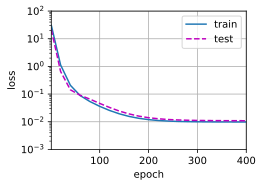

In [ ]:
# 三阶多项式函数拟合（正态）

# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.525466  4.5548086]]


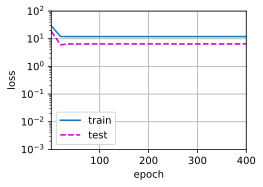

In [ ]:
# 线性函数拟合（欠拟合）

# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.9840956   1.3104033  -3.331015    5.217499   -0.2764969   0.6643781
   0.37286025  0.11807232  0.20154609 -0.00638512  0.0622729   0.06671827
  -0.128121    0.20196125 -0.07414168 -0.19489929 -0.01212264 -0.02401571
  -0.20033701  0.1261925 ]]


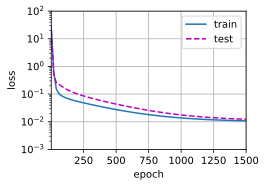

In [ ]:
# 高阶多项式拟合（过拟合）
# 多跑几次 验证数据集loss逐渐上升，很大于训练数据集的loss

# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

SVM缺点：Kernel SVM数据不大的话，几万个点都是可以做的，都是容易解的，一大的话就挺难的；能调的东西不多，例如kernel的宽度或不同的kernel，实际上效果不明显，可调性不强。

神经网络的主要优点：他是一个语言。神经网络本身是一个语言。神经网络通过神经网络这种语言来编程，来描述整个物体，整个世界，或者是整个解决问题的理解。他不像编程语言一样一行一行写下来很有逻辑性，他是比较不那么直观的，但是编程性特别好的那么一种框架。可以做很灵活的编程，例如自动求导求出来就行了。神经网络通过卷积可以做比较好的特征的提取。神经网络的特征提取和分类是放在一起做的，是真的数据集成。

理论上单隐藏层的MLP可以拟合所有的函数，实际上训练不出来。所以所有的神经网络，cnn、rnn也好，都是做一个比较好的结构，尽量帮助你训练。CNN本质上是MLP，做了一些限制，帮weight限制住了；RNN也一样，我觉得有时序信息。整个深度神经网络尽量用他的方法来描述这个数据的特性，使得训练起来更好训练一些。

这个世界有三种东西，艺术，工程，科学。艺术做了一个事情不好解释，工程很好描述CS就是工程，科学是理解是为什么。神经网络希望是科学，实际上是工程，一开始是个艺术。


SVM数学解释性很好，但是他的可编程性会差很多，可解决的问题会少很多。分类问题不大。

7:2:1 20%验证数据集做5折交叉验证。
image net有1000类，每类挑出50个做验证测试，其他都作为训练。

如果能拿到验证数据，就统一处理，拿不到就用验证数据集的均值和标准差来做标准化。

如果数据不平衡，最好是验证集50 50，否则精度不准。数据集可以不平衡，但是要使用加权使得他平衡。

n种做法：
1. 通过k折交叉验证确定超参数，再在整个数据集上做一次，最常见
2. 不重新做一遍了，把k折交叉验证中最好的那一折随便找出一个精度最好的模型拿出来
3. 把k折交叉验证的k个模型全都拿下来，把验证集每个都验证一次，然后预测结果取均值，不错的选择，但是代价增加k倍，好处因为voting增加了模型稳定性
4. Google经常干的，模型的初始权重是随机权重的，所以可以使用不同的随机权重训练5遍，得到5个模型，然后做average

VC维：我能记住的最大的数据模型长什么样子。简单理解，记单词记100个单词100维，比记10个单词的人的记忆力好一点。







